## Step-by-Step Plan for 6G Physical Layer Simulation in Smart Factory Settings

### Simulation Setup and Rationale
- **Environment Layout: 1000m x 1000m factory floor with machinery, walls, and reflective surfaces**
  - *Why*: Represents a realistic smart factory with multipath and non-line-of-sight (NLOS) conditions due to metal obstacles, critical for testing 6G signal propagation in complex indoor settings.
- **Devices: 1000 user terminals (UTs) including sensors, robots, and automated guided vehicles (AGVs)**
  - *Why*: Reflects high device density (1000+ devices per km²) to evaluate 6G’s massive connectivity for diverse factory equipment.
- **Mobility: UT velocities from 0 m/s (static sensors) to 2 m/s (moving AGVs)**
  - *Why*: Captures varied mobility patterns in factories, ensuring 6G supports both stationary and dynamic devices under Doppler effects.
- **Obstacles: Metal machinery and walls causing high path loss and shadow fading**
  - *Why*: Simulates realistic signal attenuation and interference, essential for validating 6G’s ultra-high reliability in obstructed environments.
- **Performance Targets**:
  - *Latency <1 ms*: Enables ultra-reliable low-latency communications (URLLC) for real-time robot control, critical for factory automation.
  - *BLER <10^-6*: Ensures ultra-high reliability for mission-critical applications, preventing costly errors in automated systems.
  - *Throughput up to 1 Gbps*: Supports enhanced mobile broadband (eMBB) for high-data-rate tasks like video monitoring.
  - *Why*: These metrics align with 6G’s goals to surpass 5G, addressing factory demands for speed, reliability, and responsiveness.
- **Carrier Frequency: 28 GHz (mmWave), with sub-THz (e.g., 100 GHz) testing options**
  - *Why*: mmWave offers high bandwidth for data-intensive applications, while sub-THz exploration prepares for future 6G spectrum, balancing range and capacity.
- **Bandwidth: 400 MHz, scalable to 1 GHz**
  - *Why*: Provides sufficient spectrum to achieve high throughput and low latency, with scalability to test extreme 6G scenarios.
- **Scenario: Indoor hotspot (InH) using a modified 3GPP 38.901 UMi model**
  - *Why*: Adapts a standardized model to indoor factory conditions, ensuring simulation relevance and compatibility with industry benchmarks.


### Step 1: Define Smart Factory Environment and 6G Requirements
Configure the environment to use a single GPU (if available) and import necessary libraries.

In [136]:
import os
import sionna
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.constants import c  # Speed of light
from sionna.phy.channel.tr38901 import AntennaArray
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, ResourceGridDemapper, RemoveNulledSubcarriers
from sionna.phy.mapping import Constellation, Mapper

os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Use GPU 0, or set to "" for CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Enable GPU memory growth for TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(f"Error enabling memory growth: {e}")

# Set random seed for reproducibility
sionna.phy.config.seed = 42

# Configure Matplotlib for inline plotting
%matplotlib inline
tf.get_logger().setLevel('ERROR')

# Simulation parameters
scenario = "custom_factory"  # Custom smart factory model
carrier_frequency = 28e9  # 28 GHz mmWave
bandwidth = 400e6  # 400 MHz
num_ut = 1000  # 1000 devices in 100m x 100m factory
batch_size = 128  # For Monte Carlo simulations
ut_velocity_min = 0.5  # Min velocity for AGVs (m/s)
ut_velocity_max = 2.0  # Max velocity for AGVs (m/s)
area_size = [1000, 1000, 10]  # 1000m x 1000m x 10m factory (length, width, height)
static_ratio = 0.8  # 50% of UTs are static sensors

# MIMO parameters (Step 3)
bs_num_ant = 64  # 64 antennas (8x4 dual-polarized array)
ut_num_ant = 2   # 2 antennas per UT
num_streams_per_ut = 2  # Up to 2 streams per UT
num_rf_chains = 8  # RF chains for hybrid beamforming

# OFDM parameters
subcarrier_spacing_urlcc = 120e3
subcarrier_spacing_mmtc = 30e3
fft_size_urlcc = 2048
fft_size_mmtc = 512
num_ofdm_symbols_urlcc = 7
num_ofdm_symbols_mmtc = 14
cyclic_prefix_length_urlcc = 144  # ~1 µs
cyclic_prefix_length_mmtc = 36

# Function to compute guard carriers
def compute_guard_carriers(fft_size, dc_null, num_tx, num_streams_per_tx, base_guard=10):
    total_streams = num_tx * num_streams_per_tx
    base_total = base_guard * 2
    num_effective = fft_size - dc_null - base_total
    remainder = num_effective % total_streams
    if remainder != 0:
        extra_guard = total_streams - remainder
        left_guard = base_guard + extra_guard // 2
        right_guard = base_guard + extra_guard - extra_guard // 2
    else:
        left_guard = right_guard = base_guard
    return (left_guard, right_guard)

# Compute guard carriers
guard_carriers_urlcc = compute_guard_carriers(fft_size_urlcc, dc_null=True, num_tx=1, num_streams_per_tx=num_streams_per_ut)
guard_carriers_mmtc = compute_guard_carriers(fft_size_mmtc, dc_null=True, num_tx=1, num_streams_per_tx=num_streams_per_ut)


### Step 2: Adapt Channel Model for Smart Factory

Visualizing smart factory topology...


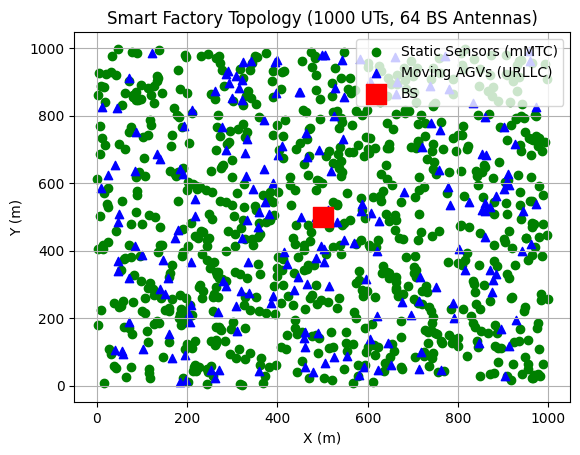

In [137]:
# Factory Channel Model
class FactoryChannelModel(nn.Module):
    def __init__(self, carrier_frequency, los_sigma=4.0, nlos_sigma=7.5, los_prob=0.3):
        super(FactoryChannelModel, self).__init__()
        self.fc = carrier_frequency
        self.los_sigma = los_sigma
        self.nlos_sigma = nlos_sigma
        self.los_prob = los_prob
        self.wavelength = c / carrier_frequency

    def path_loss(self, distance, los=True):
        pl0 = 32.4 + 17.3 * torch.log10(distance + 1e-6) + 20 * torch.log10(self.fc / 1e9)
        sf = torch.normal(0.0, self.los_sigma if los else self.nlos_sigma, distance.shape)
        return pl0 + sf

    def generate_topology(self, batch_size, num_ut, area_size, min_vel, max_vel, static_ratio):
        ut_pos = torch.rand(batch_size, num_ut, 3) * torch.tensor(area_size)
        bs_pos = torch.tensor([area_size[0]/2, area_size[1]/2, 5.0]).repeat(batch_size, 1)
        num_static = int(num_ut * static_ratio)
        velocities = torch.zeros(batch_size, num_ut)
        velocities[:, num_static:] = torch.rand(batch_size, num_ut - num_static) * (max_vel - min_vel) + min_vel
        ut_orient = torch.rand(batch_size, num_ut, 3) * 2 * np.pi
        bs_orient = torch.zeros(batch_size, 3)
        los_state = torch.rand(batch_size, num_ut) < self.los_prob
        device_type = torch.zeros(batch_size, num_ut, dtype=torch.int32)  # 0=mMTC, 1=URLLC
        device_type[:, num_static:] = 1
        return ut_pos, bs_pos, ut_orient, bs_orient, velocities, los_state, device_type

    def show_topology(self, ut_pos, bs_pos, velocities):
        static_mask = velocities[0] == 0
        moving_mask = velocities[0] > 0
        plt.scatter(ut_pos[0, static_mask, 0], ut_pos[0, static_mask, 1], c='green', marker='o', label='Static Sensors (mMTC)')
        plt.scatter(ut_pos[0, moving_mask, 0], ut_pos[0, moving_mask, 1], c='blue', marker='^', label='Moving AGVs (URLLC)')
        plt.scatter(bs_pos[0, 0], bs_pos[0, 1], c='red', marker='s', s=200, label='BS')
        plt.legend()

# Instantiate channel model
channel_model = FactoryChannelModel(
    carrier_frequency=carrier_frequency,
    los_sigma=4.0,
    nlos_sigma=7.5,
    los_prob=0.3
)

# Generate topology
ut_pos, bs_pos, ut_orient, bs_orient, velocities, los_state, device_type = channel_model.generate_topology(
    batch_size=batch_size,
    num_ut=num_ut,
    area_size=area_size,
    min_vel=ut_velocity_min,
    max_vel=ut_velocity_max,
    static_ratio=static_ratio
)

# Visualize topology
print("Visualizing smart factory topology...")
channel_model.show_topology(ut_pos, bs_pos, velocities)
plt.title(f"Smart Factory Topology ({num_ut} UTs, {bs_num_ant} BS Antennas)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.grid(True)
plt.show()


### Step 3: Enhance MIMO and Antenna Configuration

Visualizing BS antenna array geometry...


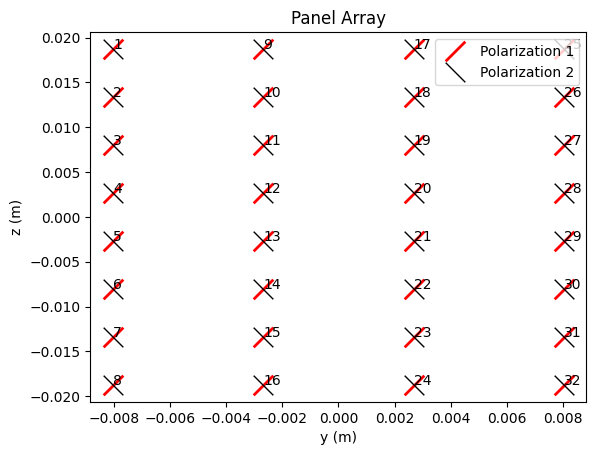

In [138]:
# Convert to TensorFlow
ut_pos_tf = tf.convert_to_tensor(ut_pos.numpy(), dtype=tf.float32)
bs_pos_tf = tf.convert_to_tensor(bs_pos.numpy(), dtype=tf.float32)
ut_orient_tf = tf.convert_to_tensor(ut_orient.numpy(), dtype=tf.float32)
bs_orient_tf = tf.convert_to_tensor(bs_orient.numpy(), dtype=tf.float32)
velocities_tf = tf.convert_to_tensor(velocities.numpy(), dtype=tf.float32)

# Antenna Array
bs_array = AntennaArray(
    num_rows=8,
    num_cols=4,
    polarization='dual',
    polarization_type='cross',
    antenna_pattern='38.901',
    carrier_frequency=carrier_frequency,
    vertical_spacing=0.5,
    horizontal_spacing=0.5
)

# Visualize BS antenna array
print("Visualizing BS antenna array geometry...")
bs_array.show()
plt.show()

ut_array = AntennaArray(
    num_rows=1,
    num_cols=2,
    polarization='single',
    polarization_type='V',
    antenna_pattern='omni',
    carrier_frequency=carrier_frequency,
    vertical_spacing=0.5,
    horizontal_spacing=0.5
)

# Stream Management
rx_tx_association = np.ones((num_ut, 1), dtype=np.int32)
stream_management = StreamManagement(
    rx_tx_association=rx_tx_association,
    num_streams_per_tx=num_streams_per_ut
)




### Step 4: Upgrade OFDM and Numerology for 6G

Visualizing URLLC Resource Grid...


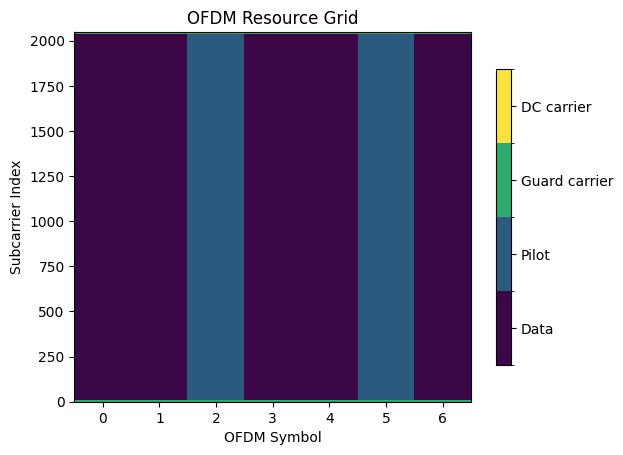

Visualizing mMTC Resource Grid...


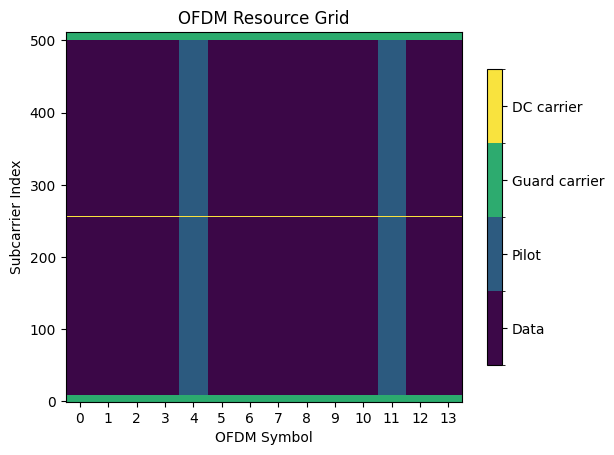

URLLC num_effective_subcarriers: 2026
mMTC num_effective_subcarriers: 490
URLLC Slot Duration: 62.43 µs
mMTC Slot Duration: 499.48 µs
Updated Channel Model and OFDM Parameters:
Scenario: custom_factory
Carrier Frequency: 28.0 GHz
Number of UTs: 1000
BS Antennas: 64
UT Antennas: 2
Streams per UT: 2
URLLC Subcarrier Spacing: 120.0 kHz
mMTC Subcarrier Spacing: 30.0 kHz
URLLC FFT Size: 2048
mMTC FFT Size: 512
OFDM Symbols per Slot (URLLC): 7
OFDM Symbols per Slot (mMTC): 14
Cyclic Prefix Length (URLLC): 144 samples
Cyclic Prefix Length (mMTC): 36 samples
Shadow Fading (LoS sigma): 4.0 dB
Shadow Fading (NLoS sigma): 7.5 dB


In [139]:
# OFDM Resource Grid
resource_grid_urlcc = ResourceGrid(
    num_ofdm_symbols=num_ofdm_symbols_urlcc,
    fft_size=fft_size_urlcc,
    subcarrier_spacing=subcarrier_spacing_urlcc,
    cyclic_prefix_length=cyclic_prefix_length_urlcc,
    num_tx=1,
    num_streams_per_tx=num_streams_per_ut,
    num_guard_carriers=guard_carriers_urlcc,
    dc_null=True,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[2, 5]
)
resource_grid_mmtc = ResourceGrid(
    num_ofdm_symbols=num_ofdm_symbols_mmtc,
    fft_size=fft_size_mmtc,
    subcarrier_spacing=subcarrier_spacing_mmtc,
    cyclic_prefix_length=cyclic_prefix_length_mmtc,
    num_tx=1,
    num_streams_per_tx=num_streams_per_ut,
    num_guard_carriers=guard_carriers_mmtc,
    dc_null=True,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[4, 11]
)

# Visualize resource grids
print("Visualizing URLLC Resource Grid...")
resource_grid_urlcc.show()
plt.show()
print("Visualizing mMTC Resource Grid...")
resource_grid_mmtc.show()
plt.show()

# Verify effective subcarriers
print(f"URLLC num_effective_subcarriers: {resource_grid_urlcc.num_effective_subcarriers}")
print(f"mMTC num_effective_subcarriers: {resource_grid_mmtc.num_effective_subcarriers}")

# Assign numerology
def assign_resource_grid(device_type):
    resource_grids = []
    for b in range(batch_size):
        rg = []
        for u in range(num_ut):
            rg.append(resource_grid_urlcc if device_type[b, u] == 1 else resource_grid_mmtc)
        resource_grids.append(rg)
    return resource_grids

resource_grids = assign_resource_grid(device_type)

# Modulation and Mapping
constellation = Constellation("qam", num_bits_per_symbol=4)
mapper = Mapper(constellation=constellation)
num_data_symbols_urlcc = resource_grid_urlcc.num_data_symbols
num_data_symbols_mmtc = resource_grid_mmtc.num_data_symbols

bits_urlcc = tf.random.uniform([batch_size, 1, num_streams_per_ut, num_data_symbols_urlcc * 4], 0, 2, dtype=tf.int32)
bits_mmtc = tf.random.uniform([batch_size, 1, num_streams_per_ut, num_data_symbols_mmtc * 4], 0, 2, dtype=tf.int32)
symbols_urlcc = mapper(bits_urlcc)
symbols_mmtc = mapper(bits_mmtc)

rg_mapper_urlcc = ResourceGridMapper(resource_grid_urlcc)
rg_mapper_mmtc = ResourceGridMapper(resource_grid_mmtc)
rg_urlcc = rg_mapper_urlcc(symbols_urlcc)
rg_mmtc = rg_mapper_mmtc(symbols_mmtc)

# Basic Channel Simulation (URLLC example)
remove_null = RemoveNulledSubcarriers(resource_grid_urlcc)
rg_urlcc_effective = remove_null(rg_urlcc)
# Placeholder: Apply channel (requires MIMO processing)
rg_demapper = ResourceGridDemapper(resource_grid_urlcc, stream_management)
# Note: Channel output requires precoding/detection (Step 5)

# Hybrid Beamforming
analog_precoder = torch.exp(1j * torch.rand(bs_num_ant, num_rf_chains) * 2 * np.pi)
digital_precoder = torch.randn(num_rf_chains, num_streams_per_ut * num_ut, dtype=torch.complex64)

# 3D Beamforming
def compute_beamforming_vectors(ut_pos, bs_pos, bs_num_ant):
    bs_pos_expanded = bs_pos.unsqueeze(1).expand(-1, ut_pos.size(1), -1)
    delta_pos = ut_pos - bs_pos_expanded
    azimuth = torch.atan2(delta_pos[:, :, 1], delta_pos[:, :, 0])
    elevation = torch.atan2(delta_pos[:, :, 2], torch.sqrt(delta_pos[:, :, 0]**2 + delta_pos[:, :, 1]**2))
    steering_vectors = torch.zeros((batch_size, num_ut, bs_num_ant), dtype=torch.complex64)
    for i in range(bs_num_ant):
        steering_vectors[:, :, i] = torch.exp(1j * 2 * np.pi * (i % 32) * torch.sin(azimuth))
    return steering_vectors

beamforming_vectors = compute_beamforming_vectors(ut_pos, bs_pos, bs_num_ant)

# Latency Calculation
slot_duration_urlcc = resource_grid_urlcc.ofdm_symbol_duration * num_ofdm_symbols_urlcc
slot_duration_mmtc = resource_grid_mmtc.ofdm_symbol_duration * num_ofdm_symbols_mmtc
print(f"URLLC Slot Duration: {slot_duration_urlcc * 1e6:.2f} µs")
print(f"mMTC Slot Duration: {slot_duration_mmtc * 1e6:.2f} µs")

# Print parameters
print("Updated Channel Model and OFDM Parameters:")
print(f"Scenario: {scenario}")
print(f"Carrier Frequency: {carrier_frequency/1e9} GHz")
print(f"Number of UTs: {num_ut}")
print(f"BS Antennas: {bs_num_ant}")
print(f"UT Antennas: {ut_num_ant}")
print(f"Streams per UT: {num_streams_per_ut}")
print(f"URLLC Subcarrier Spacing: {subcarrier_spacing_urlcc/1e3} kHz")
print(f"mMTC Subcarrier Spacing: {subcarrier_spacing_mmtc/1e3} kHz")
print(f"URLLC FFT Size: {fft_size_urlcc}")
print(f"mMTC FFT Size: {fft_size_mmtc}")
print(f"OFDM Symbols per Slot (URLLC): {num_ofdm_symbols_urlcc}")
print(f"OFDM Symbols per Slot (mMTC): {num_ofdm_symbols_mmtc}")
print(f"Cyclic Prefix Length (URLLC): {cyclic_prefix_length_urlcc} samples")
print(f"Cyclic Prefix Length (mMTC): {cyclic_prefix_length_mmtc} samples")
print(f"Shadow Fading (LoS sigma): {channel_model.los_sigma} dB")
print(f"Shadow Fading (NLoS sigma): {channel_model.nlos_sigma} dB")

### Why 1000 UTs?

- **Purpose of 1000 UTs**:
  - **High Device Density**: Simulates a future smart factory with 1000 devices (sensors, AGVs, robots, wearables) in a 1000m x 1000m area (1 device/m²), testing 6G’s massive Machine-Type Communication (mMTC) capabilities.
  - **Massive MIMO Evaluation**: Assesses massive MIMO’s ability to serve many UTs via spatial diversity and multiplexing in a dense environment.
  - **Interference Management**: Models interference in a crowded factory to evaluate 6G physical layer techniques.
  - **Future Scalability**: Prepares for growing automation trends, stress-testing 6G for future device proliferation.

- **Static vs. Moving UTs (50% Static Sensors, 50% Moving AGVs)**:
  - **Current Split**: Equal split (`static_ratio=0.5`) balances diverse device types.
  - **More Static UTs?**: Factories may have more static sensors for monitoring (low-power, intermittent data), suggesting a higher static ratio.
  - **Moving UTs’ Importance**: Fewer but critical AGVs/robots demand ultra-reliable low-latency communication (URLLC), requiring sufficient representation.

- **Can You Have Fewer UTs?**:
  - **Yes**: Fewer UTs (e.g., 10–100) suit initial algorithm testing, specific use cases, or resource constraints, reducing computational load.
  - **Trade-Off**: Lower UT counts may not fully stress-test 6G’s scalability or interference management.

- **Relevance to Future Factories**:
  - 1000 UTs reflect hyper-automation trends, enabling bottleneck identification, scalability testing, and innovation in 6G technologies for dense deployments.

### Do All UTs Need Higher Capacity?

- **Factory UTs**:
  - UTs have varied needs: static sensors (50% of 1000 UTs) transmit small, periodic data, prioritizing ultra-reliable low-latency communication (URLLC, BLER < 10^-6, latency < 1 ms); AGVs/robots need high throughput (100 Mbps–1 Gbps) for enhanced mobile broadband (eMBB) applications.
  - Massive MIMO benefits all UTs by improving signal quality and supporting dense connectivity (1000 UTs/km²).

- **High-Capacity Applications for Machine Communications**:
  - **Video Surveillance/Analytics**: AGVs stream 4K video (50–500 Mbps) for monitoring/defect detection, using 400 MHz bandwidth.
  - **3D Mapping/Localization**: AGVs/robots send LiDAR data (100–300 Mbps) for navigation, aided by 3D beamforming.
  - **Collaborative Robot Control**: Cobots share multi-modal data (50–200 Mbps) for synchronized tasks, supported by 2 antennas per UT.
  - **AR for Maintenance**: Robots use AR streams (100–500 Mbps) for digital twins, needing low latency and high throughput.
  - **Sensor Data Aggregation**: 500 sensors’ aggregated data (up to 1 Gbps) requires high BS capacity, enabled by massive MIMO.

- **Conclusion**: Only AGVs/robots (50% of UTs) need high capacity for eMBB applications. Sensors prioritize reliability over throughput. Massive MIMO optimizes capacity allocation, ensuring scalability and QoS. Simulation tweaks (e.g., variable streams, throughput modeling) can confirm this heterogeneity.

### Prof. Adee Tasks 07-05-2025:
1. Expand area size and number of UTs. ✅
2. Clarify differences between UMi and UMi calibration. ✅
3. For indoor UTs (LoS + NLoS), enhance topology visualization. ✅
4. Verify the `gen_single_sector_topology` function. ✅

### References
1. **3GPP TR 38.901**: "Study on channel model for frequencies from 0.5 to 100 GHz." Defines UMi and InH models. Available at: https://www.3gpp.org/ftp/Specs/archive/38_series/38.901/
2. **ITU-R M.2160**: "Framework and overall objectives of the future development of IMT for 2030 and beyond." Outlines 6G requirements. Available at: https://www.itu.int/rec/R-REC-M.2160
3. **Sionna Documentation**: Details on channel models and topology generation. Available at: https://nvlabs.github.io/sionna/phy/api/channel.wireless.html
4. **Z. Zhang et al., "6G Wireless Networks: Vision, Requirements, Architecture, and Key Technologies,"** IEEE Vehicular Technology Magazine, 2019. DOI: 10.1109/MVT.2019.2921394
5. **M. Katz et al., "6G and the Factory of the Future,"** 6G Flagship White Paper, 2020. Available at: https://www.6gflagship.com/
6. **T. S. Rappaport et al., "Millimeter Wave Mobile Communications for 5G Cellular: It Will Work!,"** IEEE Access, 2013. DOI: 10.1109/ACCESS.2013.2260813